Re-program the implicit differentiation optimization to check whether the program is corrected

Observations:
- Even I set the the weight to be very close to w, the loss still fuctuates.
    - Thought: Maybe the update is too stochastic? Learning rate too high? or rand in x? Too small dataset?, no bias term?
    - Answer: rand in x, Fix by randn in x, increases number of epochs
- Predicted loss < True loss means do we find a better line than the one we are generated?
    - Happens when x is generated with rand (uniform generation) and when regularization

Conclusions:
- The SGD solution is approximately equal to the closed-form solution

This Section is using L2 regularization
Observations:
- The higher the lamb value, the higher the training loss and the more difference between closed-form weight solution and SGD weight solution.

The following block combines the optimization of weight and hyperparameter together
Observations:
    - The training loss still decreases even when the hyperparameter is wrong, but after hyperparameter adjusts, the training loss seems to decrease compared to previous hepoch, but not during epoch.
        - Question: Does this mean the loss already converge? Does this mean optimizing lambda is not important?
        - Thought: Which hyperparameter should we optimize?
    - After epoch 200, the hyperparameter becomes negative, but stop at -0.0927. Used the optimal weight, the loss is even higher compared with the lambda = 0.01
        - Question: Overfitting?
    - Training epoch vs Hyperparam epoch
    - Note: We have individual lambda for each weight in implicit optimization code
    - Note: Train loss and validation loss in implicit opt code always decrease, train acc and validation acc also increases, but the test loss INCREASES, and the test acc DOES NOT improve


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable

Redesign the experiment: Creating an overfitting situation

In [2]:
torch.manual_seed(1)

# Generate the dataset
x = torch.randn((60,1))
size_x = x.size()
poly_x = torch.cat((x, x**2, x**3, x**4, x**5), 1)

# Add one column to learn intercept terms
x_ones = torch.cat((torch.ones(size_x), x),1)
poly_x_ones = torch.cat((torch.ones(size_x),poly_x), 1)

true_w = torch.tensor([[1.], [2.]])
y = torch.matmul(x_ones, true_w) + torch.randn(size_x)
true_y = torch.matmul(x_ones, true_w)

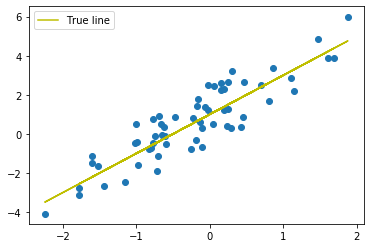

In [3]:
plt.clf()
plt.scatter(x, y)
plt.plot(x, true_y, color='y', label='True line')
plt.legend(loc='best')

In [4]:
# Separate the train and the valid
x_train = x_ones[:25,]
y_train = y[:25,]

x_valid = x_ones[25:50,]
y_valid = y[25:50,]

x_test = x_ones[50:,]
y_test = y[50:,]

poly_x_train = poly_x_ones[:25,]
poly_x_valid = poly_x_ones[25:50,]
poly_x_test = poly_x_ones[50:,]


In [5]:
#Parameters and hyperparameters
w = torch.tensor([[2.5], [1.3]], requires_grad=True)
poly_w = torch.tensor([[2.5], [1.3], [2.], [1.], [-1.], [-0.5]], requires_grad=True)

lamb = torch.tensor([3.], requires_grad=True)
lamb_small = 0.1
lamb_big = 10

#Define optimizer (Note: The choice of optimizer is similar to the problem setting)
optimizer = torch.optim.Adam([w], lr = 0.001)
poly_optimizer = torch.optim.Adam([poly_w], lr=0.001)

h_optimizer = torch.optim.RMSprop([lamb])

Calculate w_hat using closed-form solution (linear function)

In [6]:
w_hat = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x_train.T, x_train)), x_train.T), y_train)
print('w_hat: ', w_hat)
y_train_predicted = torch.matmul(x_train, w_hat)
train_loss = torch.nn.functional.mse_loss(y_train_predicted, y_train)
print('train loss: ', train_loss)
y_valid_predicted = torch.matmul(x_valid, w_hat)
valid_loss = torch.nn.functional.mse_loss(y_valid_predicted, y_valid)
print('val loss: ', valid_loss)
y_test_predicted = torch.matmul(x_test, w_hat)
test_loss = torch.nn.functional.mse_loss(y_test_predicted, y_test)
print('test loss: ', test_loss)

w_hat:  tensor([[1.0418],
        [1.8727]])
train loss:  tensor(0.6892)
val loss:  tensor(0.8736)
test loss:  tensor(0.8084)


Calculate poly_w_hat using closed-form solution (5-th order function)

In [7]:
poly_w_hat = torch.matmul(torch.matmul(torch.inverse(torch.matmul(poly_x_train.T, poly_x_train)), poly_x_train.T), y_train)
print('poly_w_hat: ', poly_w_hat)
poly_y_train_predicted = torch.matmul(poly_x_train, poly_w_hat)
poly_train_loss = torch.nn.functional.mse_loss(poly_y_train_predicted, y_train)
print('poly train loss: ', poly_train_loss)
poly_y_valid_predicted = torch.matmul(poly_x_valid, poly_w_hat)
poly_val_loss = torch.nn.functional.mse_loss(poly_y_valid_predicted, y_valid)
print('poly val loss: ', poly_val_loss)
poly_y_test_predicted = torch.matmul(poly_x_test, poly_w_hat)
poly_test_loss = torch.nn.functional.mse_loss(poly_y_test_predicted, y_test)
print('poly test loss: ', poly_test_loss)

poly_w_hat:  tensor([[ 1.2561],
        [ 2.0045],
        [-0.7074],
        [ 0.3434],
        [ 0.2656],
        [-0.1909]])
poly train loss:  tensor(0.6040)
poly val loss:  tensor(6.0787)
poly test loss:  tensor(1.7954)


Note:
- Train loss is smaller, but validation loss for polynomial regression is greater than linear regression.
- The weights for first order are similar to true weights, whereas the weights for 5-th order are very off.
Conclusion:
- Overfitting!! (The plot below shows this issue)

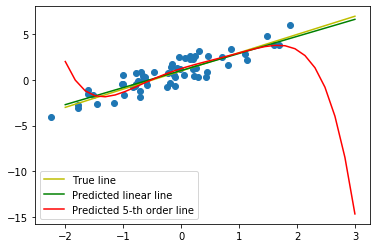

In [8]:
# x, y here simply for visualization
x_plot = torch.linspace(-2, 3, steps = 30)
x_plot = x_plot.resize_((x_plot.size(0), 1))
plot_size = x_plot.size()
x_plot_ones = torch.cat((torch.ones(plot_size), x_plot), 1)
poly_x_plot_ones = torch.cat((torch.ones(plot_size), x_plot, x_plot**2, x_plot**3,x_plot**4,x_plot**5),1)
y_plot = torch.matmul(x_plot_ones, true_w)

plt.clf()
plt.scatter(x, y)
plt.plot(x_plot, y_plot, color='y', label='True line')
plt.plot(x_plot, torch.matmul(x_plot_ones, w_hat), color='g', label='Predicted linear line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat), color='r', label='Predicted 5-th order line')
plt.legend(loc='best')

Run with SGD to show how close the closed-form solution with SGD solution

SGD linear solution is [1.1712, 2.0772], which is very close to the closed-form linear solution. The training loss and validation loss are also similar

In [9]:
epoch = 5000
for ep in range(epoch):
    total_train_loss = 0
    for i in range(len(x_train)):
        optimizer.zero_grad()
        y_predicted = torch.matmul(x_train[i], w)
        train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i])
        total_train_loss += train_loss
        train_loss.backward()
        optimizer.step()
    print('Train loss at ' + str(ep) + ': ' + str(total_train_loss / len(x_train)))
    print('w at ' + str(ep) + ': ' +  str(w))
y_valid_predicted = torch.matmul(x_valid, w)
val_loss = torch.nn.functional.mse_loss(y_valid_predicted, y_valid)
print('val loss: ', val_loss)
y_test_predicted = torch.matmul(x_test, w)
test_loss = torch.nn.functional.mse_loss(y_test_predicted, y_test)
print('test loss: ', test_loss)

Train loss at 0: tensor(3.4188, grad_fn=<DivBackward0>)
w at 0: tensor([[2.4779],
        [1.3157]], requires_grad=True)
Train loss at 1: tensor(3.3321, grad_fn=<DivBackward0>)
w at 1: tensor([[2.4572],
        [1.3269]], requires_grad=True)
Train loss at 2: tensor(3.2512, grad_fn=<DivBackward0>)
w at 2: tensor([[2.4364],
        [1.3381]], requires_grad=True)
Train loss at 3: tensor(3.1718, grad_fn=<DivBackward0>)
w at 3: tensor([[2.4158],
        [1.3492]], requires_grad=True)
Train loss at 4: tensor(3.0942, grad_fn=<DivBackward0>)
w at 4: tensor([[2.3954],
        [1.3602]], requires_grad=True)
Train loss at 5: tensor(3.0182, grad_fn=<DivBackward0>)
w at 5: tensor([[2.3750],
        [1.3711]], requires_grad=True)
Train loss at 6: tensor(2.9442, grad_fn=<DivBackward0>)
w at 6: tensor([[2.3549],
        [1.3820]], requires_grad=True)
Train loss at 7: tensor(2.8719, grad_fn=<DivBackward0>)
w at 7: tensor([[2.3349],
        [1.3927]], requires_grad=True)
Train loss at 8: tensor(2.8014, 

SGD 5-th-order solution is [1.0739, 0.1508, -1.9155, 1.2932, 0.6961, -0.2947], which is also close to closed-form 5-th-order solution (Increasing the number of epochs can make SGD solution closer to closed-form). The training loss and validation loss are also close

In [10]:
torch.manual_seed(1)
epoch = 5000
for ep in range(epoch):
    total_poly_train_loss = 0
    for i in range(len(poly_x_train)):
        if i == 0 and ep == 0:
            print('poly w before update :', poly_w)
        poly_optimizer.zero_grad()
        poly_y_predicted = torch.matmul(poly_x_train[i], poly_w)
        poly_train_loss = torch.nn.functional.mse_loss(poly_y_predicted, y_train[i])
        total_poly_train_loss += poly_train_loss
        poly_train_loss.backward()
        poly_optimizer.step()
    print('poly train loss at ' + str(ep) + ': ' + str(total_poly_train_loss / len(poly_x_train)))
    print('poly w at ' + str(ep) + ': ' +  str(poly_w))
poly_y_valid_predicted = torch.matmul(poly_x_valid, poly_w)
loss = torch.nn.functional.mse_loss(poly_y_valid_predicted, y_valid)
print('val loss: ', loss)
poly_y_test_predicted = torch.matmul(poly_x_test, poly_w)
test_loss = torch.nn.functional.mse_loss(poly_y_test_predicted, y_test)
print('test loss: ', test_loss)

poly w before update : tensor([[ 2.5000],
        [ 1.3000],
        [ 2.0000],
        [ 1.0000],
        [-1.0000],
        [-0.5000]], requires_grad=True)
poly train loss at 0: tensor(5.2708, grad_fn=<DivBackward0>)
poly w at 0: tensor([[ 2.4794],
        [ 1.3175],
        [ 1.9883],
        [ 1.0142],
        [-1.0074],
        [-0.4875]], requires_grad=True)
poly train loss at 1: tensor(5.0347, grad_fn=<DivBackward0>)
poly w at 1: tensor([[ 2.4603],
        [ 1.3279],
        [ 1.9799],
        [ 1.0235],
        [-1.0100],
        [-0.4791]], requires_grad=True)
poly train loss at 2: tensor(4.8516, grad_fn=<DivBackward0>)
poly w at 2: tensor([[ 2.4415],
        [ 1.3376],
        [ 1.9719],
        [ 1.0322],
        [-1.0120],
        [-0.4713]], requires_grad=True)
poly train loss at 3: tensor(4.6868, grad_fn=<DivBackward0>)
poly w at 3: tensor([[ 2.4229],
        [ 1.3469],
        [ 1.9642],
        [ 1.0404],
        [-1.0137],
        [-0.4639]], requires_grad=True)
poly t

The plot supports our finding!!

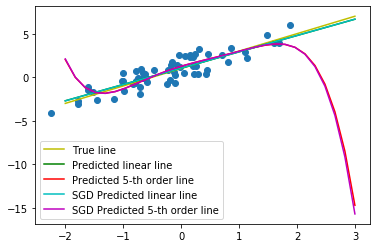

In [11]:
plt.clf()
plt.scatter(x, y)
plt.plot(x_plot, y_plot, color='y', label='True line')
plt.plot(x_plot, torch.matmul(x_plot_ones, w_hat), color='g', label='Predicted linear line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat), color='r', label='Predicted 5-th order line')
plt.plot(x_plot, torch.matmul(x_plot_ones, w.detach()), color='c', label='SGD Predicted linear line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w.detach()), color='m', label='SGD Predicted 5-th order line')
plt.legend(loc='best')

Let try to see whether regularization mitigates the issue of 5th-order polynomial

Regularization in the closed-form solution (5th-order)

- lambda = 0, validation loss is 2.3155, train loss is 0.3299
- lambda = 0.01, validation loss is 2.4932, train loss is 0.3197
- lambda = 0.1, validation loss is 2.1449, train loss is 0.3231
- lambda = 1, validation loss is 1.4020, train loss is 0.3689
- lambda = 3, validation loss is 1.1258, train loss is 0.4397
- lambda = 5, validation loss is 1.0027, train loss is  0.4885
- lambda = 10, validation loss is 0.8118, train loss is 0.5774

It seems lambda = 0.01 giving the optimal train loss and validation loss

In [12]:
poly_w_hat_lambda_small = torch.matmul(torch.matmul(torch.inverse(torch.matmul(poly_x_train.T, poly_x_train) + lamb_small * torch.eye(6)), poly_x_train.T), y_train)
print('w_hat: ', poly_w_hat_lambda_small)
train_loss = torch.nn.functional.mse_loss(torch.matmul(poly_x_train, poly_w_hat_lambda_small), y_train)
print('train loss: ', train_loss)
val_loss = torch.nn.functional.mse_loss(torch.matmul(poly_x_valid, poly_w_hat_lambda_small), y_valid)
print('val loss: ', val_loss)
test_loss = torch.nn.functional.mse_loss(torch.matmul(poly_x_test, poly_w_hat_lambda_small), y_test)
print('test loss: ', test_loss)

w_hat:  tensor([[ 1.2205],
        [ 1.9164],
        [-0.6259],
        [ 0.4632],
        [ 0.2412],
        [-0.2226]])
train loss:  tensor(0.6048)
val loss:  tensor(6.4769)
test loss:  tensor(1.7678)


In [13]:
poly_w_hat_lambda_large = torch.matmul(torch.matmul(torch.inverse(torch.matmul(poly_x_train.T, poly_x_train) + lamb_big * torch.eye(6)), poly_x_train.T), y_train)
print('w_hat: ', poly_w_hat_lambda_small)
train_loss = torch.nn.functional.mse_loss(torch.matmul(poly_x_train, poly_w_hat_lambda_large), y_train)
print('train loss: ', train_loss)
val_loss = torch.nn.functional.mse_loss(torch.matmul(poly_x_valid, poly_w_hat_lambda_large), y_valid)
print('val loss: ', val_loss)
test_loss = torch.nn.functional.mse_loss(torch.matmul(poly_x_test, poly_w_hat_lambda_large), y_test)
print('test loss: ', test_loss)

w_hat:  tensor([[ 1.2205],
        [ 1.9164],
        [-0.6259],
        [ 0.4632],
        [ 0.2412],
        [-0.2226]])
train loss:  tensor(1.1213)
val loss:  tensor(1.1685)
test loss:  tensor(0.7753)


Plot with small regularizer (0.1) and large regularizer (10)

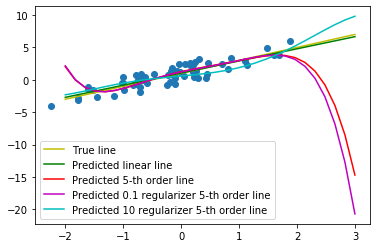

In [14]:
plt.clf()
plt.scatter(x, y)
plt.plot(x_plot, y_plot, color='y', label='True line')
plt.plot(x_plot, torch.matmul(x_plot_ones, w_hat), color='g', label='Predicted linear line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat), color='r', label='Predicted 5-th order line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat_lambda_small), color='m', label='Predicted 0.1 regularizer 5-th order line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat_lambda_large), color='c', label='Predicted 10 regularizer 5-th order line')
plt.legend(loc='best')

SGD with small lambda (0.1): Weight = [0.7069, 0.5956, -0.3327, 0.6495, 0.1421, -0.0831], train loss = 0.5740, val loss = 1.3126
SGD with big lambda (10): Weight = [0.0389, 0.0579, 0.0122, 0.1167,-0.0202, 0.0517], train loss = 1.8189, val loss = 0.2263
- Note: SGD method with both small and big lambda has worse training loss, but better val loss

In [15]:
torch.manual_seed(1)
poly_w_lambda_small = torch.tensor([[2.5], [1.3], [2.], [1.], [-1.], [-0.5]], requires_grad=True)
poly_lambda_small_optimizer = torch.optim.Adam([poly_w_lambda_small], lr=0.001)
epoch = 5000
for ep in range(epoch):
    total_poly_train_loss = 0
    for i in range(len(poly_x_train)):
        if i == 0 and ep == 0:
            print('poly w before update :', poly_w_lambda_small)
        poly_lambda_small_optimizer.zero_grad()
        poly_y_predicted = torch.matmul(poly_x_train[i], poly_w_lambda_small)
        poly_train_loss = torch.nn.functional.mse_loss(poly_y_predicted, y_train[i]) + lamb_small  * torch.sum(poly_w_lambda_small ** 2)
        total_poly_train_loss += poly_train_loss
        poly_train_loss.backward()
        poly_lambda_small_optimizer.step()
    print('poly train loss at ' + str(ep) + ': ' + str(total_poly_train_loss / len(poly_x_train)))
    print('poly w at ' + str(ep) + ': ' +  str(poly_w_lambda_small))
poly_y_valid_predicted = torch.matmul(poly_x_valid, poly_w_lambda_small)
val_loss = torch.nn.functional.mse_loss(poly_y_valid_predicted, y_valid)
print('val loss: ', val_loss)
poly_y_test_predicted = torch.matmul(poly_x_test, poly_w_lambda_small)
test_loss = torch.nn.functional.mse_loss(poly_y_test_predicted, y_test)
print('test loss: ', test_loss)

poly w before update : tensor([[ 2.5000],
        [ 1.3000],
        [ 2.0000],
        [ 1.0000],
        [-1.0000],
        [-0.5000]], requires_grad=True)
poly train loss at 0: tensor(6.6844, grad_fn=<DivBackward0>)
poly w at 0: tensor([[ 2.4787],
        [ 1.3168],
        [ 1.9872],
        [ 1.0138],
        [-1.0071],
        [-0.4874]], requires_grad=True)
poly train loss at 1: tensor(6.4361, grad_fn=<DivBackward0>)
poly w at 1: tensor([[ 2.4587],
        [ 1.3260],
        [ 1.9773],
        [ 1.0226],
        [-1.0093],
        [-0.4789]], requires_grad=True)
poly train loss at 2: tensor(6.2404, grad_fn=<DivBackward0>)
poly w at 2: tensor([[ 2.4389],
        [ 1.3344],
        [ 1.9679],
        [ 1.0308],
        [-1.0110],
        [-0.4710]], requires_grad=True)
poly train loss at 3: tensor(6.0631, grad_fn=<DivBackward0>)
poly w at 3: tensor([[ 2.4193],
        [ 1.3423],
        [ 1.9587],
        [ 1.0385],
        [-1.0122],
        [-0.4635]], requires_grad=True)
poly t

SGD with big lambda

In [16]:
torch.manual_seed(1)
poly_w_lambda_large = torch.tensor([[2.5], [1.3], [2.], [1.], [-1.], [-0.5]], requires_grad=True)
poly_lambda_large_optimizer = torch.optim.Adam([poly_w_lambda_large], lr=0.001)
epoch = 5000
for ep in range(epoch):
    total_poly_train_loss = 0
    for i in range(len(poly_x_train)):
        if i == 0 and ep == 0:
            print('poly w before update :', poly_w_lambda_large)
        poly_lambda_large_optimizer.zero_grad()
        poly_y_predicted = torch.matmul(poly_x_train[i], poly_w_lambda_large)
        poly_train_loss = torch.nn.functional.mse_loss(poly_y_predicted, y_train[i]) + lamb_big  * torch.sum(poly_w_lambda_large ** 2)
        total_poly_train_loss += poly_train_loss
        poly_train_loss.backward()
        poly_lambda_large_optimizer.step()
    print('poly train loss at ' + str(ep) + ': ' + str(total_poly_train_loss / len(poly_x_train)))
    print('poly w at ' + str(ep) + ': ' +  str(poly_w_lambda_large))
poly_y_valid_predicted = torch.matmul(poly_x_valid, poly_w_lambda_large)
val_loss = torch.nn.functional.mse_loss(poly_y_valid_predicted, y_valid)
print('val loss: ', val_loss)
poly_y_test_predicted = torch.matmul(poly_x_test, poly_w_lambda_large)
test_loss = torch.nn.functional.mse_loss(poly_y_test_predicted, y_test)
print('val loss: ', test_loss)

poly w before update : tensor([[ 2.5000],
        [ 1.3000],
        [ 2.0000],
        [ 1.0000],
        [-1.0000],
        [-0.5000]], requires_grad=True)
poly train loss at 0: tensor(145.3372, grad_fn=<DivBackward0>)
poly w at 0: tensor([[ 2.4751],
        [ 1.2749],
        [ 1.9755],
        [ 0.9768],
        [-0.9805],
        [-0.4817]], requires_grad=True)
poly train loss at 1: tensor(141.3776, grad_fn=<DivBackward0>)
poly w at 1: tensor([[ 2.4503],
        [ 1.2500],
        [ 1.9509],
        [ 0.9540],
        [-0.9606],
        [-0.4658]], requires_grad=True)
poly train loss at 2: tensor(137.5276, grad_fn=<DivBackward0>)
poly w at 2: tensor([[ 2.4255],
        [ 1.2256],
        [ 1.9264],
        [ 0.9317],
        [-0.9410],
        [-0.4500]], requires_grad=True)
poly train loss at 3: tensor(133.7721, grad_fn=<DivBackward0>)
poly w at 3: tensor([[ 2.4009],
        [ 1.2015],
        [ 1.9020],
        [ 0.9098],
        [-0.9217],
        [-0.4344]], requires_grad=True

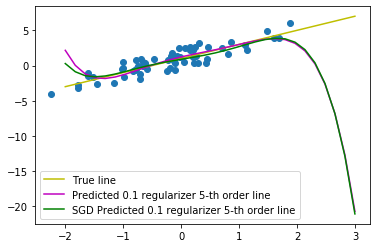

In [17]:
plt.clf()
plt.scatter(x, y)
plt.plot(x_plot, y_plot, color='y', label='True line')
# plt.plot(x_plot, torch.matmul(x_plot_ones, w_hat), color='g', label='Predicted linear line')
# plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat), color='r', label='Predicted 5-th order line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat_lambda_small), color='m', label='Predicted 0.1 regularizer 5-th order line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_lambda_small.detach()), color='g', label='SGD Predicted 0.1 regularizer 5-th order line')

plt.legend(loc='best')

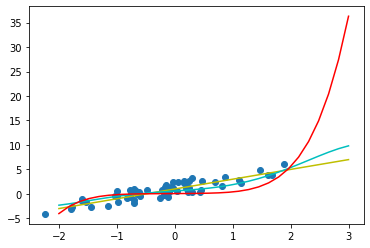

In [18]:
plt.clf()
plt.scatter(x, y)
plt.plot(x_plot, y_plot, color='y', label='True line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat_lambda_large), color='c', label='Predicted 10 regularizer 5-th order line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_lambda_large.detach()), color='r', label='SGD Predicted 10 regularizer 5-th order line')
plt.legend(loc='best')

Hyperparameter optimization with no Hessian approximation

In [19]:
h_epoch = 10000
poly_w_lambda = torch.tensor([[2.5], [1.3], [2.], [1.], [-1.], [-0.5]], requires_grad=True)
poly_lambda_optimizer = torch.optim.Adam([poly_w_lambda], lr=0.001)
for hep in range(h_epoch):
    # Train (SGD)
    for ep in range(epoch):
        total_train_loss = 0
        for i in range(len(poly_x_train)):
            poly_lambda_optimizer.zero_grad()
            y_predicted = torch.matmul(poly_x_train[i], poly_w_lambda)
            train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i]) + lamb * torch.sum(poly_w_lambda ** 2)
            total_train_loss += train_loss
            train_loss.backward(create_graph=True)
            poly_lambda_optimizer.step()
        if ep % 1000 == 0: # Only print every 100 epoch
            print('Train loss at ' + str(ep) + ': ' + str(total_train_loss / len(x_train)))

    # Train the hyperparameter
    total_d_val_loss_d_lamb = torch.zeros(lamb.size())
    d_valid_loss_d_w = torch.zeros(poly_w_lambda.size())
    for i in range(len(poly_x_valid)):
        poly_w_lambda.grad.zero_()
        y_predicted = torch.matmul(poly_x_valid[i], poly_w_lambda)
        valid_loss = torch.nn.functional.mse_loss(y_predicted, y_valid[i])
        valid_loss_grad = grad(valid_loss, poly_w_lambda)
        d_valid_loss_d_w += valid_loss_grad[0]
    d_valid_loss_d_w /= len(poly_x_valid)

    for i in range(len(poly_x_train)):
        y_predicted = torch.matmul(poly_x_train[i], poly_w_lambda)
        train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i]) + lamb * torch.sum(poly_w_lambda ** 2)
        poly_w_lambda.grad.zero_(), h_optimizer.zero_grad()
        d_train_loss_d_w = grad(train_loss, poly_w_lambda, create_graph=True)

        poly_w_lambda.grad.zero_(), h_optimizer.zero_grad()
        d_train_loss_d_w[0].backward(d_valid_loss_d_w)

        if lamb.grad is not None:
            total_d_val_loss_d_lamb -= lamb.grad
    total_d_val_loss_d_lamb /= len(poly_x_train)

    lamb.grad = total_d_val_loss_d_lamb
    h_optimizer.step()

    poly_w_lambda.grad.zero_(), h_optimizer.zero_grad()
    print('lamb after epoch '+ str(hep) + ': ' + str(lamb))
    print('w value: ', poly_w_lambda)

    print('train loss: ',  torch.nn.functional.mse_loss(torch.matmul(poly_x_train, poly_w_lambda), y_train))
    print('val loss: ', torch.nn.functional.mse_loss(torch.matmul(poly_x_valid, poly_w_lambda), y_valid))
    print('test loss: ', torch.nn.functional.mse_loss(torch.matmul(poly_x_test, poly_w_lambda), y_test))

Train loss at 0: tensor([47.4349], grad_fn=<DivBackward0>)
Train loss at 1000: tensor([2.4217], grad_fn=<DivBackward0>)
Train loss at 2000: tensor([2.4217], grad_fn=<DivBackward0>)
Train loss at 3000: tensor([2.4217], grad_fn=<DivBackward0>)
Train loss at 4000: tensor([2.4217], grad_fn=<DivBackward0>)
lamb after epoch 0: tensor([3.1000], requires_grad=True)
w value:  tensor([[0.1707],
        [0.1938],
        [0.0518],
        [0.1439],
        [0.0605],
        [0.1335]], requires_grad=True)
train loss:  tensor(2.0836, grad_fn=<MseLossBackward>)
val loss:  tensor(2.1494, grad_fn=<MseLossBackward>)
test loss:  tensor(1.0588, grad_fn=<MseLossBackward>)
Train loss at 0: tensor([2.4331], grad_fn=<DivBackward0>)
Train loss at 1000: tensor([2.4326], grad_fn=<DivBackward0>)
Train loss at 2000: tensor([2.4326], grad_fn=<DivBackward0>)
Train loss at 3000: tensor([2.4326], grad_fn=<DivBackward0>)
Train loss at 4000: tensor([2.4326], grad_fn=<DivBackward0>)
lamb after epoch 1: tensor([3.1712], 

KeyboardInterrupt: 

Hyperparameter optimization with Hessian approximation

In [ ]:
h_epoch = 10000
poly_w_lambda = torch.tensor([[2.5], [1.3], [2.], [1.], [-1.], [-0.5]], requires_grad=True)
poly_lambda_optimizer = torch.optim.Adam([poly_w_lambda], lr=0.001)
for hep in range(h_epoch):
    # Train (SGD)
    for ep in range(epoch):
        total_train_loss = 0
        for i in range(len(poly_x_train)):
            poly_lambda_optimizer.zero_grad()
            y_predicted = torch.matmul(poly_x_train[i], poly_w_lambda)
            train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i]) + lamb * torch.sum(poly_w_lambda ** 2)
            total_train_loss += train_loss
            train_loss.backward(create_graph=True)
            poly_lambda_optimizer.step()
        if ep % 1000 == 0: # Only print every 100 epoch
            print('Train loss at ' + str(ep) + ': ' + str(total_train_loss / len(x_train)))

    # Train the hyperparameter
    total_d_val_loss_d_lamb = torch.zeros(lamb.size())
    d_valid_loss_d_w = torch.zeros(poly_w_lambda.size())
    for i in range(len(poly_x_valid)):
        poly_w_lambda.grad.zero_()
        y_predicted = torch.matmul(poly_x_valid[i], poly_w_lambda)
        valid_loss = torch.nn.functional.mse_loss(y_predicted, y_valid[i])
        valid_loss_grad = grad(valid_loss, poly_w_lambda)
        d_valid_loss_d_w += valid_loss_grad[0]
    d_valid_loss_d_w /= len(poly_x_valid)

    for i in range(len(poly_x_train)):
        y_predicted = torch.matmul(poly_x_train[i], poly_w_lambda)
        train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i]) + lamb * torch.sum(poly_w_lambda ** 2)
        poly_w_lambda.grad.zero_(), h_optimizer.zero_grad()
        d_train_loss_d_w = grad(train_loss, poly_w_lambda, create_graph=True)

        poly_w_lambda.grad.zero_(), h_optimizer.zero_grad()
        d_train_loss_d_w[0].backward(d_valid_loss_d_w)

        if lamb.grad is not None:
            total_d_val_loss_d_lamb -= lamb.grad
    total_d_val_loss_d_lamb /= len(poly_x_train)

    lamb.grad = total_d_val_loss_d_lamb
    h_optimizer.step()

    poly_w_lambda.grad.zero_(), h_optimizer.zero_grad()
    print('lamb after epoch '+ str(hep) + ': ' + str(lamb))
    print('w value: ', poly_w_lambda)

    print('train loss: ',  torch.nn.functional.mse_loss(torch.matmul(poly_x_train, poly_w_lambda), y_train))
    print('val loss: ', torch.nn.functional.mse_loss(torch.matmul(poly_x_valid, poly_w_lambda), y_valid))
    print('test loss: ', torch.nn.functional.mse_loss(torch.matmul(poly_x_test, poly_w_lambda), y_test))

In [ ]:
#TODO: Set up the cuda for faster training
#TODO: Set up wandb to monitor loss, weight, hyperparameter
#TODO: Set up the code for non-approximate Hessian
#TODO: Debug the code
#TODO: Code the actor-critic